In [2]:
from glob import glob
import random

import numpy as np
import xarray as xr
import salem
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from python import wind_utils as wu
from python import climate_utils as cu
from python import utils as pu

## Bias-correction

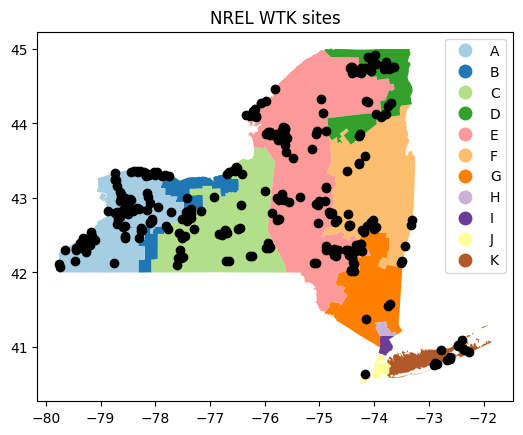

In [4]:
# Show WTK locations
df_wtk = wu.read_all_wtk(keep_every=10)
latlons = df_wtk[['wtk_lat', 'wtk_lon']].value_counts().index.unique()

# Load NYISO
nyiso_gdf = gpd.read_file(f"{pu.project_path}/data/nyiso/gis/NYISO_Load_Zone_Dissolved.shp")

# Plot
fig, ax = plt.subplots()
nyiso_gdf.plot(column='zone', legend=True, cmap='Paired', ax=ax)
lats = latlons.get_level_values(0)
lons = latlons.get_level_values(1)
ax.scatter(lons, lats, color='black')
ax.set_title('NREL WTK sites')

plt.savefig('../../figs/nrel_wtk_sites_every10.png', dpi=300, bbox_inches='tight')

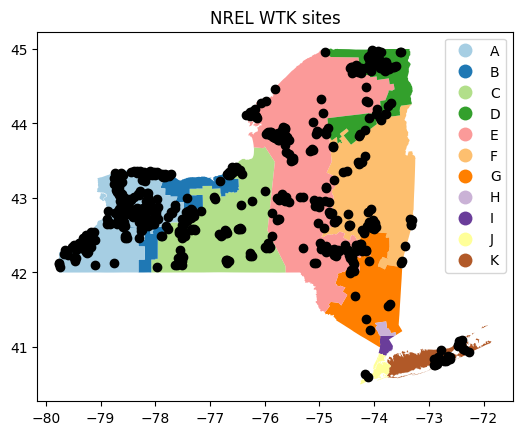

In [5]:
# Show WTK locations
df_wtk = wu.read_all_wtk(keep_every=5)
latlons = df_wtk[['wtk_lat', 'wtk_lon']].value_counts().index.unique()

# Load NYISO
nyiso_gdf = gpd.read_file(f"{pu.project_path}/data/nyiso/gis/NYISO_Load_Zone_Dissolved.shp")

# Plot
fig, ax = plt.subplots()
nyiso_gdf.plot(column='zone', legend=True, cmap='Paired', ax=ax)
lats = latlons.get_level_values(0)
lons = latlons.get_level_values(1)
ax.scatter(lons, lats, color='black')
ax.set_title('NREL WTK sites')

plt.savefig('../../figs/nrel_wtk_sites_every5.png', dpi=300, bbox_inches='tight')

### Analysis

In [14]:
%%time
# Get TGW input wind data
start_year = 2007
end_year = 2013
wtk_keep_every = 5

climate_paths = cu.generate_tgw_filelist('historical_1980_2019', [start_year, end_year])

df = wu.prepare_wind_data(
    climate_paths = climate_paths,
    wind_vars = ['U10', 'V10'],
    lat_name="south_north",
    lon_name="west_east",
    curvilinear=True,
    parallel=True,
    wtk_keep_every=wtk_keep_every,
)

CPU times: user 7min 58s, sys: 6min 20s, total: 14min 18s
Wall time: 24min 28s


In [15]:
# Compute and store the stability coefficients
res = wu.get_stability_coefficients(df, 'ws', 'ws_wtk').reset_index()
res.to_csv(f"{pu.project_path}/data/wind/models/tgw_stability_coefficients_{start_year}-{end_year}_every{wtk_keep_every}.csv", index=False)

### Plots

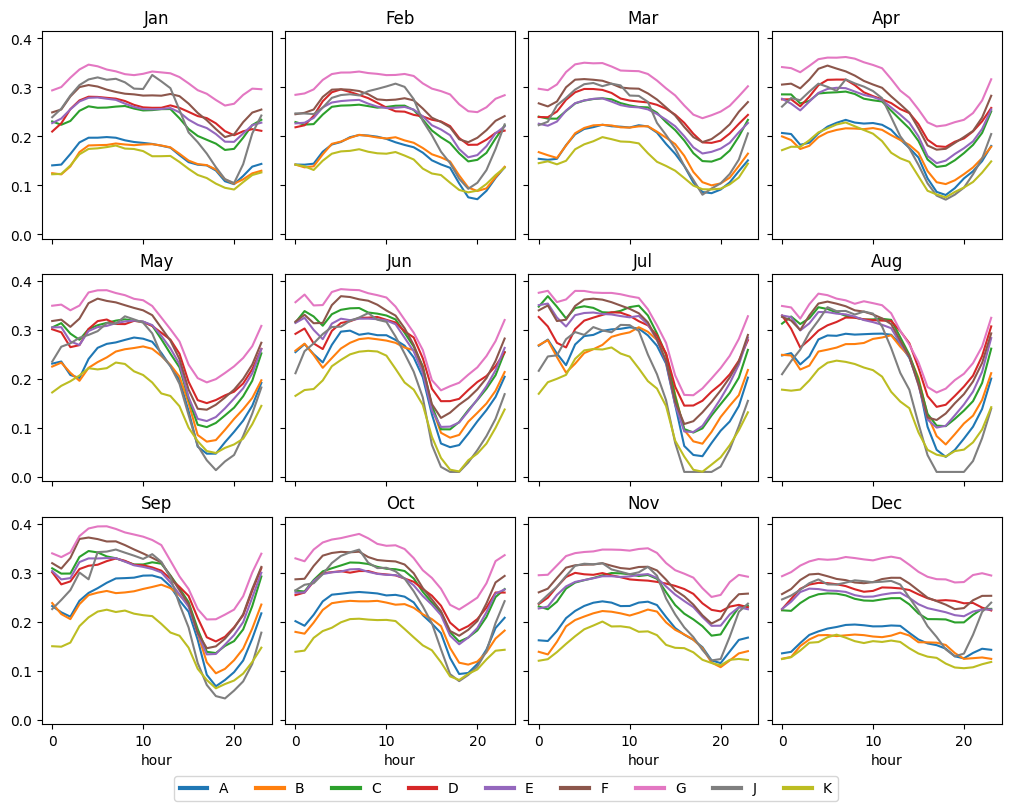

In [18]:
# Plot the stability coefficients
fig, axs = plt.subplots(3, 4, figsize=(10,8), layout='constrained', sharey=True, sharex=True)
axs = axs.flatten()

for month in range(1,13):
    ax = axs[month-1]
    for idz, zone in enumerate(res['zone'].unique()):
        res_sel = res[(res['month'] == month) & (res['zone'] == zone)]
        res_sel.plot(x='hour', y='alpha', color=f"C{idz}", legend=False, ax=ax)
    ax.set_title(pu.month_names[month-1])

# Add legend
handles = [Line2D([0], [0], color=f"C{idz}", label=zone, lw=3) for idz, zone in enumerate(res['zone'].unique())]
fig.legend(handles = handles,
          loc='outside lower center',
          ncol=len(handles))

plt.savefig('../../figs/wind_stability_coeffs.png', dpi=300, bbox_inches='tight')

In [19]:
# Merge and plot results
df = pd.merge(df, res, on =['hour', 'month', 'zone'])

# Calculate corrected windspeed
df['ws_corrected'] = df['ws'] * (100/10)**df['alpha']

# Get unique latlons
latlons = df[['wtk_lat', 'wtk_lon']].value_counts().index.unique()

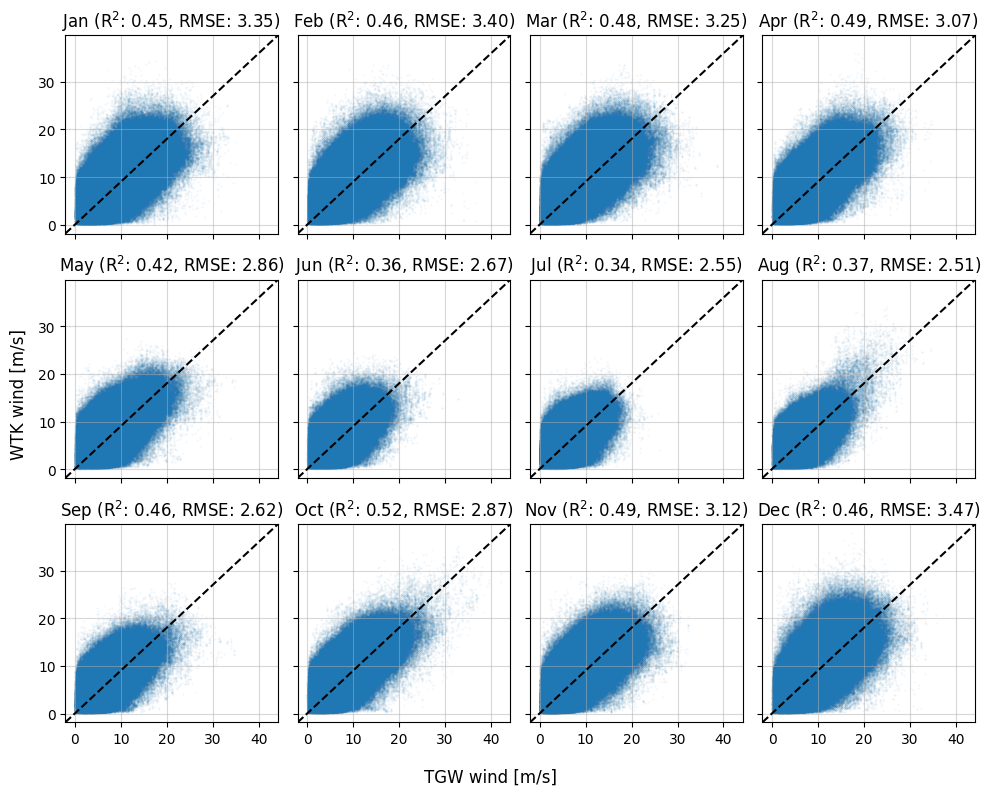

In [23]:
# Plot the fit results
fig, axs = plt.subplots(3, 4, figsize=(10,8), layout='tight', sharey=True, sharex=True)
axs = axs.flatten()

for month in range(1,13):
    ax = axs[month-1]
    df_tmp = df[df['month'] == month]
    
    df_tmp.plot.scatter(x='ws_corrected', y='ws_wtk', legend=False, ax=ax, alpha=0.1, s=0.1)

    # Add fit info
    r2 = (np.corrcoef(df_tmp.dropna()['ws_corrected'], df_tmp.dropna()['ws_wtk'])[0, 1]** 2)
    rmse = np.sqrt(np.mean((df_tmp.dropna()['ws_corrected'] - df_tmp.dropna()['ws_wtk']) ** 2))
    # Add 1:1 line
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="black")

    ax.set_title(f"{pu.month_names[month-1]} (R$^2$: {r2:.2f}, RMSE: {rmse:.2f})")
    ax.grid(alpha=0.5)
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supylabel('WTK wind [m/s]')
fig.supxlabel('TGW wind [m/s]')

plt.savefig('../../figs/wind_fit.png', dpi=300, bbox_inches='tight')
# plt.show()

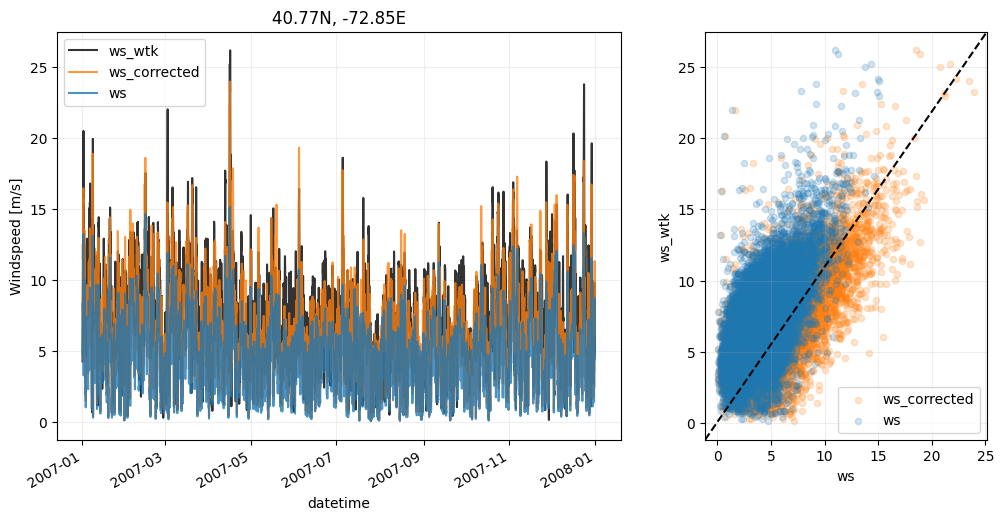

In [21]:
# Plot example timeseries
lat, lon = latlons[5]
year = 2007

df_sel = df[(df['wtk_lat'] == lat) & (df['wtk_lon'] == lon) & (df['datetime'].dt.year == year)]

fig, axs = plt.subplots(1, 2, figsize=(12,6), width_ratios=[5,2.5])

# Timeseries
ax = axs[0]
df_sel.plot(x='datetime', y='ws_wtk', alpha=0.8, ax=ax, color='black')
df_sel.plot(x='datetime', y='ws_corrected', alpha=0.8, ax=ax, color='C1')
df_sel.plot(x='datetime', y='ws', alpha=0.8, ax=ax, color='C0')
ax.set_ylabel('Windspeed [m/s]')
ax.set_title(f"{lat:.2f}N, {lon:.2f}E")
ax.grid(alpha=0.2)

# Scatter
ax = axs[1]
df_sel.plot.scatter(x='ws_corrected', y='ws_wtk', alpha=0.2, ax=ax, color='C1', label='ws_corrected')
df_sel.plot.scatter(x='ws', y='ws_wtk', alpha=0.2, ax=ax, color='C0', label='ws')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="black")
ax.legend()
ax.grid(alpha=0.2)

plt.savefig('../../figs/wind_example.png', dpi=300, bbox_inches='tight')

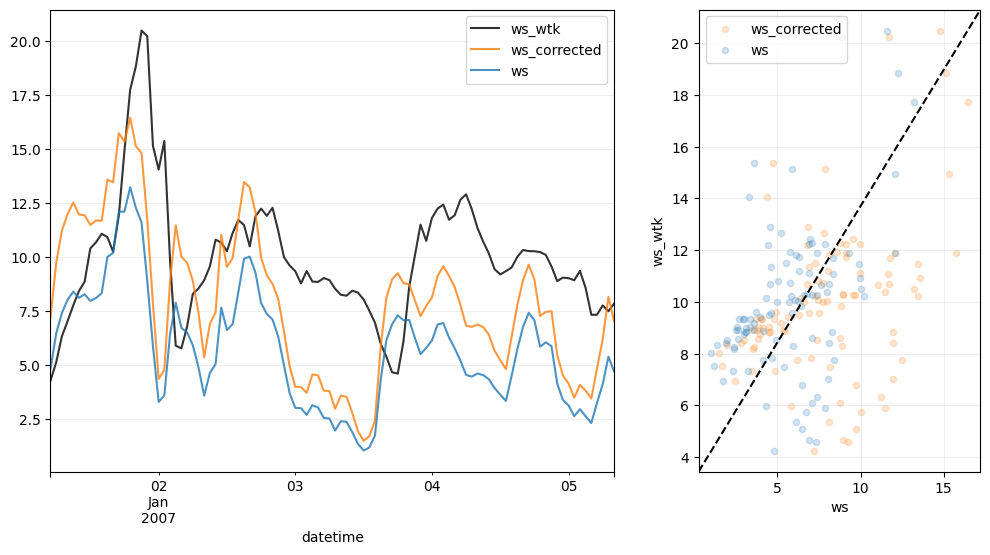

In [22]:
# Plot example timeseries
lat, lon = latlons[5]
year = 2007

df_sel = df[(df['wtk_lat'] == lat) & (df['wtk_lon'] == lon) & (df['datetime'].dt.year == year)][0:100]

fig, axs = plt.subplots(1, 2, figsize=(12,6), width_ratios=[5,2.5])

# Timeseries
ax = axs[0]
df_sel.plot(x='datetime', y='ws_wtk', alpha=0.8, ax=ax, color='black')
df_sel.plot(x='datetime', y='ws_corrected', alpha=0.8, ax=ax, color='C1')
df_sel.plot(x='datetime', y='ws', alpha=0.8, ax=ax, color='C0')

ax.grid(alpha=0.2)

# Scatter
ax = axs[1]
df_sel.plot.scatter(x='ws_corrected', y='ws_wtk', alpha=0.2, ax=ax, color='C1', label='ws_corrected')
df_sel.plot.scatter(x='ws', y='ws_wtk', alpha=0.2, ax=ax, color='C0', label='ws')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="black")
ax.legend()
ax.grid(alpha=0.2)

plt.show()